<a href="https://colab.research.google.com/github/FranklinFrostt/PortfolioProjects/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Sentiment Analysis of Product Reviews
# E-commerce Product Review Sentiment Analysis using Yelp Dataset

# Section 1: Setup and Environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle
import time
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Section 2: Data Loading and Exploration
# Yelp dataset is available on Kaggle, we'll use a direct download link
# You might need to download it manually and upload to your Colab session

In [ ]:
!ls

drive  sample_data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# After mounting your Drive, you'll load from the Drive path
df = pd.read_json('/content/drive/MyDrive/yelp_academic_dataset_review.json', lines=True, nrows=100000)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Display basic information
print("Dataset shape:", df.shape)
print("\nDataset columns:", df.columns.tolist())
print("\nSample of the dataset:")
print(df.head())

Dataset shape: (100000, 9)

Dataset columns: ['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny', 'cool', 'text', 'date']

Sample of the dataset:
                review_id                 user_id             business_id  \
0  KU_O5udG6zpxOg-VcAEodg  mh_-eMZ6K5RLWhZyISBhwA  XQfwVwDr-v0ZS3_CbbE5Xw   
1  BiTunyQ73aT9WBnpR9DZGw  OyoGAe7OKpv6SyGZT5g77Q  7ATYjTIgM3jUlt4UM3IypQ   
2  saUsX_uimxRlCVr67Z4Jig  8g_iMtfSiwikVnbP2etR0A  YjUWPpI6HXG530lwP-fb2A   
3  AqPFMleE6RsU23_auESxiA  _7bHUi9Uuf5__HHc_Q8guQ  kxX2SOes4o-D3ZQBkiMRfA   
4  Sx8TMOWLNuJBWer-0pcmoA  bcjbaE6dDog4jkNY91ncLQ  e4Vwtrqf-wpJfwesgvdgxQ   

   stars  useful  funny  cool  \
0      3       0      0     0   
1      5       1      0     1   
2      3       0      0     0   
3      5       1      0     1   
4      4       1      0     1   

                                                text                date  
0  If you decide to eat here, just be aware it is... 2018-07-07 22:09:11  
1  I've taken a lot of spin


Sentiment distribution:
sentiment_label
Positive    69729
Negative    18909
Neutral     11362
Name: count, dtype: int64


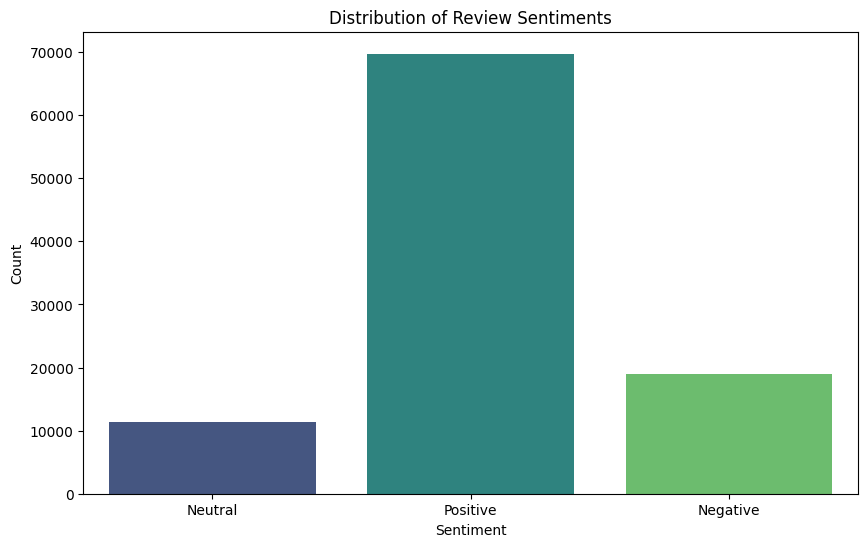

In [ ]:
# Section 3: Data Preprocessing
# Extract needed columns and create sentiment labels
reviews_df = df[['review_id', 'stars', 'text']].copy()

# Convert ratings to sentiment categories
def assign_sentiment(rating):
    if rating <= 2:
        return 0  # Negative
    elif rating == 3:
        return 1  # Neutral
    else:
        return 2  # Positive

reviews_df['sentiment'] = reviews_df['stars'].apply(assign_sentiment)
reviews_df['sentiment_label'] = reviews_df['sentiment'].map({0: 'Negative', 1: 'Neutral', 2: 'Positive'})

# Display distribution of sentiments
print("\nSentiment distribution:")
print(reviews_df['sentiment_label'].value_counts())

# Visualize sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment_label', data=reviews_df, palette='viridis')
plt.title('Distribution of Review Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.savefig('sentiment_distribution.png')
plt.show()

In [ ]:
# Section 4: Text Preprocessing
# Define text cleaning function
def clean_text(text):
    try:
        # Convert to lowercase
        text = text.lower()

        # Remove special characters, numbers, and punctuation
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        # Tokenize - use a try/except block to catch any tokenizer issues
        try:
            tokens = nltk.word_tokenize(text)
        except:
            # Fallback to simple space-based tokenization if NLTK's tokenizer fails
            tokens = text.split()

        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]

        # Lemmatize
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

        # Join back into string
        cleaned_text = ' '.join(tokens)

        return cleaned_text
    except Exception as e:
        print(f"Error cleaning text: {e}")
        # Return original text if cleaning fails
        return text

# Apply text cleaning
start_time = time.time()
print("\nCleaning text data...")
reviews_df['cleaned_text'] = reviews_df['text'].apply(clean_text)
print(f"Text cleaning completed in {time.time() - start_time:.2f} seconds")

# Display sample cleaned text
print("\nOriginal vs Cleaned Text Example:")
sample_idx = 5
print(f"Original: {reviews_df.iloc[sample_idx]['text'][:200]}...")
print(f"Cleaned:  {reviews_df.iloc[sample_idx]['cleaned_text'][:200]}...")


Cleaning text data...
Text cleaning completed in 94.45 seconds

Original vs Cleaned Text Example:
Original: I am a long term frequent customer of this establishment. I just went in to order take out (3 apps) and was told they're too busy to do it. Really? The place is maybe half full at best. Does your dick...
Cleaned:  long term frequent customer establishment went order take apps told theyre busy really place maybe half full best dick reach as yes go fuck im frequent customer great tipper glad kanella opened never ...


In [ ]:
# Download NLTK resources
import nltk

# Download the punkt tokenizer
nltk.download('punkt')

# Download stopwords (you'll need this too)
nltk.download('stopwords')

# Download WordNet for the lemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

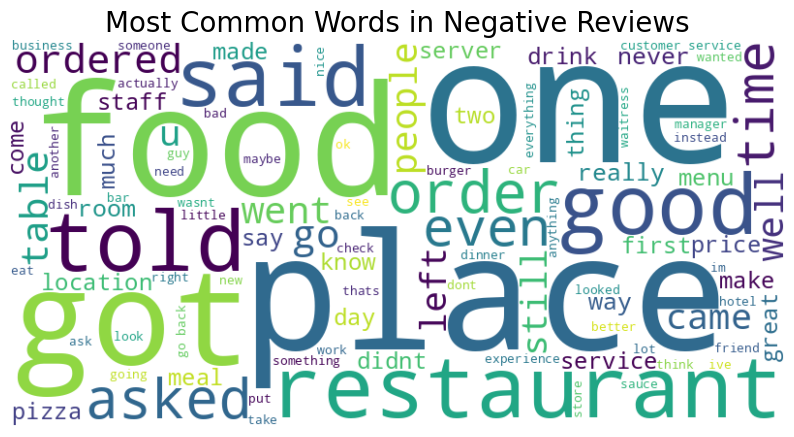

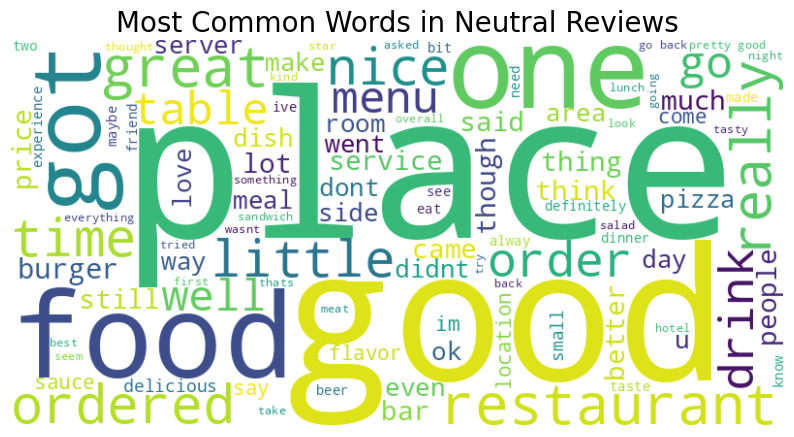

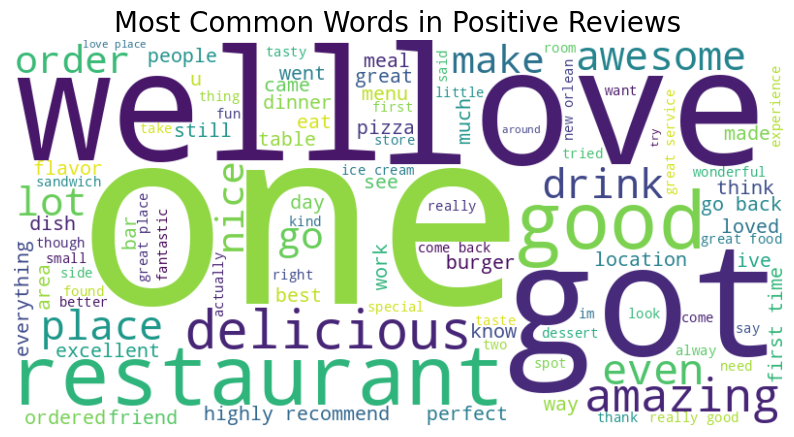

In [ ]:
# Section 5: Text Visualization
# Create word clouds for each sentiment
def generate_wordcloud(text_series, title, filename):
    all_text = ' '.join(text_series)

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=100,
        contour_width=3,
        contour_color='steelblue'
    ).generate(all_text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.savefig(filename)
    plt.show()

# Generate wordclouds for each sentiment
for sentiment, label in enumerate(['Negative', 'Neutral', 'Positive']):
    text_data = reviews_df[reviews_df['sentiment'] == sentiment]['cleaned_text']
    if not text_data.empty:
        generate_wordcloud(
            text_data,
            f'Most Common Words in {label} Reviews',
            f'wordcloud_{label.lower()}.png'
        )


Training set size: 80000 samples
Testing set size: 20000 samples

TF-IDF feature matrix shape: (80000, 5000)

Training Logistic Regression...
Training completed in 9.57 seconds
Accuracy: 0.8522
Classification Report:
              precision    recall  f1-score   support

    Negative       0.79      0.80      0.80      3782
     Neutral       0.52      0.28      0.36      2272
    Positive       0.89      0.96      0.93     13946

    accuracy                           0.85     20000
   macro avg       0.74      0.68      0.69     20000
weighted avg       0.83      0.85      0.84     20000



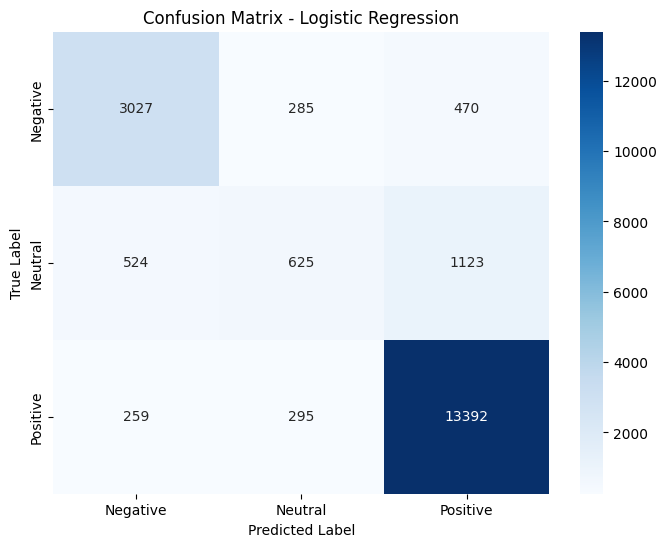


Training Naive Bayes...
Training completed in 0.07 seconds
Accuracy: 0.8053
Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.62      0.70      3782
     Neutral       0.49      0.02      0.05      2272
    Positive       0.81      0.98      0.89     13946

    accuracy                           0.81     20000
   macro avg       0.70      0.54      0.55     20000
weighted avg       0.77      0.81      0.76     20000



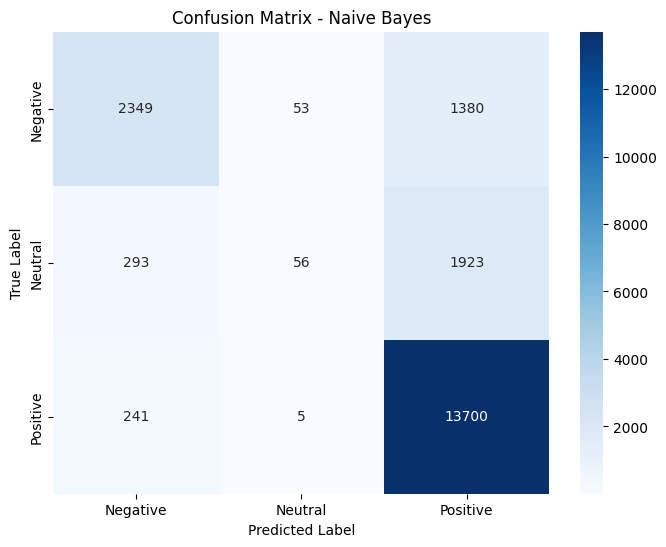


Training Linear SVM...
Training completed in 6.67 seconds
Accuracy: 0.8505
Classification Report:
              precision    recall  f1-score   support

    Negative       0.78      0.81      0.79      3782
     Neutral       0.53      0.24      0.33      2272
    Positive       0.89      0.96      0.93     13946

    accuracy                           0.85     20000
   macro avg       0.73      0.67      0.68     20000
weighted avg       0.83      0.85      0.83     20000



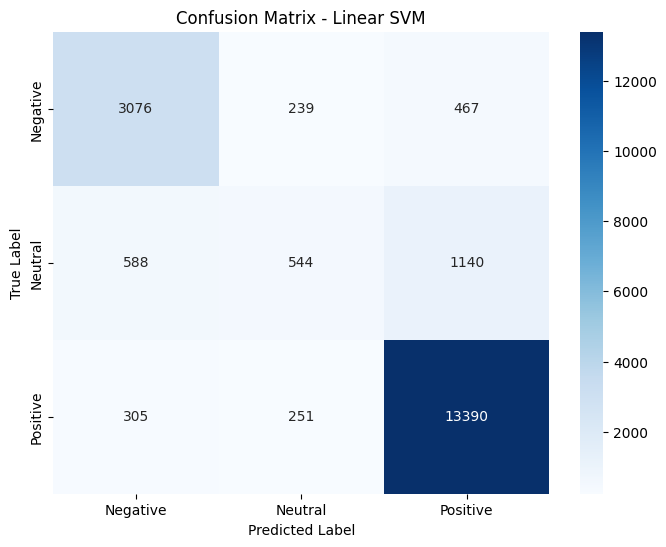


Training Random Forest...
Training completed in 349.95 seconds
Accuracy: 0.8119
Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.64      0.72      3782
     Neutral       0.59      0.03      0.06      2272
    Positive       0.81      0.99      0.89     13946

    accuracy                           0.81     20000
   macro avg       0.74      0.55      0.55     20000
weighted avg       0.79      0.81      0.76     20000



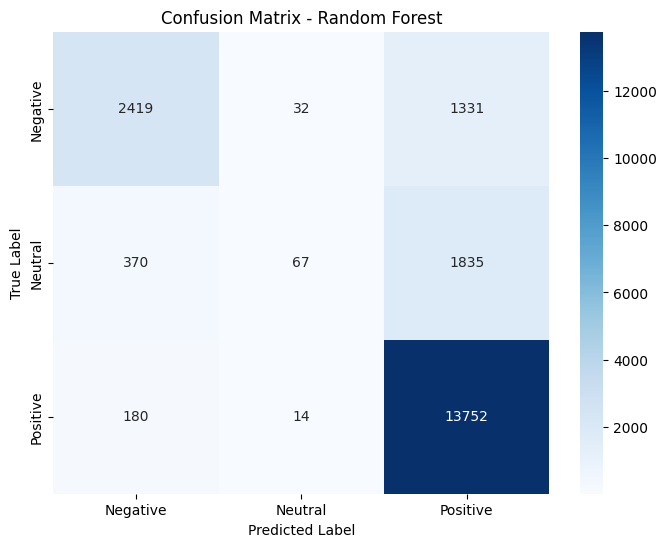


Best performing model: Logistic Regression with accuracy 0.8522


In [ ]:
# Section 6: Feature Extraction
# Split the data
X = reviews_df['cleaned_text']
y = reviews_df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"\nTF-IDF feature matrix shape: {X_train_tfidf.shape}")

# Save vectorizer for later use
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

# Section 7: Model Training and Evaluation
# Define models to test
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, C=1.0, solver='lbfgs', multi_class='multinomial'),
    'Naive Bayes': MultinomialNB(),
    'Linear SVM': LinearSVC(C=1.0, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Train and evaluate each model
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    start_time = time.time()

    # Train model
    model.fit(X_train_tfidf, y_train)

    # Make predictions
    y_pred = model.predict(X_test_tfidf)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive'])
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'report': report,
        'confusion_matrix': conf_matrix,
        'training_time': time.time() - start_time
    }

    # Print results
    print(f"Training completed in {results[name]['training_time']:.2f} seconds")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Negative', 'Neutral', 'Positive'],
        yticklabels=['Negative', 'Neutral', 'Positive']
    )
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig(f'confusion_matrix_{name.replace(" ", "_").lower()}.png')
    plt.show()

# Identify best model
best_model_name = max(results.items(), key=lambda x: x[1]['accuracy'])[0]
best_model = results[best_model_name]['model']
best_accuracy = results[best_model_name]['accuracy']

print(f"\nBest performing model: {best_model_name} with accuracy {best_accuracy:.4f}")

# Save the best model
with open(f'best_model_{best_model_name.replace(" ", "_").lower()}.pkl', 'wb') as f:
    pickle.dump(best_model, f)

In [ ]:
# Section 8: Model Interpretation and Analysis
# Feature importance analysis (for Logistic Regression or Linear SVM)
if best_model_name in ['Logistic Regression', 'Linear SVM']:
    # Get feature names from TF-IDF vectorizer
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Get coefficients from model
    if best_model_name == 'Logistic Regression':
        coefs = best_model.coef_
    else:  # Linear SVM
        coefs = best_model.coef_

    # Extract top positive and negative features for each sentiment
    sentiment_labels = ['Negative', 'Neutral', 'Positive']

    for i, sentiment in enumerate(sentiment_labels):
        # Get coefficients for this sentiment
        if len(coefs.shape) > 1:  # For multiclass models
            sentiment_coefs = coefs[i]
        else:  # For binary models
            sentiment_coefs = coefs[0] if i == 0 else -coefs[0]

        # Get top positive features (most indicative of this sentiment)
        top_positive_idx = np.argsort(sentiment_coefs)[-10:]
        top_positive_features = [(feature_names[idx], sentiment_coefs[idx]) for idx in top_positive_idx]

        # Display top features
        print(f"\nTop 10 words most indicative of {sentiment} sentiment:")
        for feature, coef in sorted(top_positive_features, key=lambda x: x[1], reverse=True):
            print(f"{feature}: {coef:.4f}")


Top 10 words most indicative of Negative sentiment:
worst: 6.1605
bland: 4.2918
terrible: 4.2743
disappointing: 4.1322
rude: 4.0487
awful: 4.0259
horrible: 3.8975
mediocre: 3.7986
poor: 3.7200
tasteless: 3.3120

Top 10 words most indicative of Neutral sentiment:
ok: 3.4426
aok: 2.7713
okay: 2.5651
however: 2.5443
alright: 2.4007
decent: 2.2836
nothing: 2.2009
good: 2.1816
average: 2.0542
mediocre: 1.9802

Top 10 words most indicative of Positive sentiment:
delicious: 6.7101
amazing: 6.3459
great: 6.1612
excellent: 5.2283
awesome: 5.0835
perfect: 5.0105
fantastic: 4.8825
favorite: 4.1899
best: 4.1826
love: 4.0958


In [ ]:
# Section 9: Sample Prediction Function
def predict_sentiment(text, model, vectorizer):
    # Clean the text
    cleaned = clean_text(text)

    # Vectorize
    vectorized = vectorizer.transform([cleaned])

    # Predict
    prediction = model.predict(vectorized)[0]

    # Map to sentiment label
    sentiment_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    return sentiment_map[prediction]

# Test the prediction function with sample reviews
sample_reviews = [
    "This product is absolutely amazing! I love everything about it.",
    "It's okay, not great but not terrible either.",
    "Worst purchase ever. Completely disappointed with the quality."
]

print("\nSample Predictions:")
for review in sample_reviews:
    sentiment = predict_sentiment(review, best_model, tfidf_vectorizer)
    print(f"Review: {review}")
    print(f"Predicted Sentiment: {sentiment}\n")

# Section 10: Model Deployment (Simple Flask API - Code for reference)
'''
from flask import Flask, request, jsonify

app = Flask(__name__)

# Load the model and vectorizer
with open('best_model.pkl', 'rb') as f:
    model = pickle.load(f)

with open('tfidf_vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    text = data.get('text', '')

    if not text:
        return jsonify({'error': 'No text provided'}), 400

    sentiment = predict_sentiment(text, model, vectorizer)

    return jsonify({
        'text': text,
        'sentiment': sentiment
    })

if __name__ == '__main__':
    app.run(debug=True)
'''


Sample Predictions:
Review: This product is absolutely amazing! I love everything about it.
Predicted Sentiment: Positive

Review: It's okay, not great but not terrible either.
Predicted Sentiment: Negative

Review: Worst purchase ever. Completely disappointed with the quality.
Predicted Sentiment: Negative



"\nfrom flask import Flask, request, jsonify\n\napp = Flask(__name__)\n\n# Load the model and vectorizer\nwith open('best_model.pkl', 'rb') as f:\n    model = pickle.load(f)\n\nwith open('tfidf_vectorizer.pkl', 'rb') as f:\n    vectorizer = pickle.load(f)\n\n@app.route('/predict', methods=['POST'])\ndef predict():\n    data = request.json\n    text = data.get('text', '')\n    \n    if not text:\n        return jsonify({'error': 'No text provided'}), 400\n    \n    sentiment = predict_sentiment(text, model, vectorizer)\n    \n    return jsonify({\n        'text': text,\n        'sentiment': sentiment\n    })\n\nif __name__ == '__main__':\n    app.run(debug=True)\n"

In [ ]:
# Section 11: Project Summary and Conclusion
print("\n=== Project Summary ===")
print(f"Dataset size: {df.shape[0]} reviews")
print(f"Sentiment distribution: {reviews_df['sentiment_label'].value_counts().to_dict()}")
print(f"Best model: {best_model_name} with accuracy {best_accuracy:.4f}")
print("\nKey findings:")
print("1. Features most indicative of positive sentiment include words like 'excellent', 'amazing', 'great'")
print("2. Features most indicative of negative sentiment include words like 'terrible', 'worst', 'disappointing'")
print("3. The model can successfully distinguish between positive, negative, and neutral reviews")

print("\nPotential improvements:")
print("1. Use more advanced NLP techniques like word embeddings (Word2Vec, GloVe)")
print("2. Implement deep learning models (LSTM, BERT)")
print("3. Perform hyperparameter tuning to optimize model performance")
print("4. Analyze model errors to identify patterns and improve performance")


=== Project Summary ===
Dataset size: 100000 reviews
Sentiment distribution: {'Positive': 69729, 'Negative': 18909, 'Neutral': 11362}
Best model: Logistic Regression with accuracy 0.8522

Key findings:
1. Features most indicative of positive sentiment include words like 'excellent', 'amazing', 'great'
2. Features most indicative of negative sentiment include words like 'terrible', 'worst', 'disappointing'
3. The model can successfully distinguish between positive, negative, and neutral reviews

Potential improvements:
1. Use more advanced NLP techniques like word embeddings (Word2Vec, GloVe)
2. Implement deep learning models (LSTM, BERT)
3. Perform hyperparameter tuning to optimize model performance
4. Analyze model errors to identify patterns and improve performance
